In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from torch import nn, optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx




In [3]:
# Read in connectomes
test_connectome = pd.read_csv('TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
train_connectome = pd.read_csv('TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')

In [4]:
# Read in solutions 

# Denoising Autoencoder DAE

In [5]:
# Merge Connectome
merged_connectome = pd.concat([train_connectome, test_connectome], ignore_index=True)

Hypertuning parameters to consider
- Latent dimension 
- Learning rate
- Beta coefficient
- Network architecture
- Attention mechanism 

In [6]:
merged_connectome.shape

(1517, 19901)

In [7]:
test_connectome

participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0     Cfwaf5FX7jWK          0.548480          0.713607          0.557319   
1     vhGrzmvA3Hjq          0.427740          0.363022          0.402862   
2     ULliyEXjy4OV          0.139572          0.390106         -0.087041   
3     LZfeAb1xMtql          0.133561          0.778326          0.416355   
4     EnFOUv0YK1RG          0.126699          0.575446          0.509422   
..             ...               ...               ...               ...   
299   UadZfjdEg7eG          0.029721          0.596742          0.361898   
300   IUEHiLmQAqCi          0.025985          0.347840          0.304804   
301   cRySmCadYFRO          0.105385          0.443624         -0.019777   
302   E3MvDUtJadc5          0.345641          0.758986          0.748153   
303   dQJXfyRazknD          0.574983          0.497672          0.206867   

     0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolumn  \
0            0.524369          0.693364          0.770032          0.724406   
1            0.363003          0.534558          0.345347          0.409471   
2            0.196852          0.088148          0.023843          0.381782   
3            0.471840          0.568460          0.633660          0.501113   
4            0.363193          0.427544          0.449924          0.451796   
..                ...               ...               ...               ...   
299          0.292066          0.553130          0.476284          0.543970   
300          0.463090          0.305321          0.267397          0.468712   
301          0.435582          0.376492          0.619322          0.430177   
302          0.442141          0.571924          0.485011          0.530513   
303          0.443488          0.283010          0.502524          0.350450   

     0throw_8thcolumn  0throw_9thcolumn  ...  195throw_196thcolumn  \
0            0.390118          0.547912  ...              0.080423   
1            0.303328          0.402515  ...              0.198009   
2            0.068979          0.377488  ...              0.051319   
3            0.345461          0.467943  ...              0.046183   
4            0.223927          0.298248  ...              0.315734   
..                ...               ...  ...                   ...   
299          0.372932          0.595183  ...              0.021524   
300          0.155677          0.298155  ...              0.044974   
301          0.567600          0.399820  ...              0.145582   
302          0.137672          0.467144  ...              0.036169   
303          0.113193          0.239293  ...              0.194971   

     195throw_197thcolumn  195throw_198thcolumn  195throw_199thcolumn  \
0               -0.054581             -0.088163             -0.028574   
1               -0.000724              0.083122              0.033043   
2                0.023630             -0.056819              0.117396   
3               -0.238962              0.121868             -0.260970   
4                0.002234              0.290791              0.344149   
..                    ...                   ...                   ...   
299             -0.162832              0.105546              0.028975   
300             -0.078047             -0.118271              0.035741   
301              0.004455              0.134574             -0.152951   
302             -0.345563             -0.165280             -0.347035   
303              0.144088              0.007635              0.126100   

     196throw_197thcolumn  196throw_198thcolumn  196throw_199thcolumn  \
0                0.444847              0.350149             -0.012601   
1                0.687497              0.306229              0.717485   
2                0.576086              0.517831              0.527044   
3                0.646818              0.594902              0.608156   
4                0.480214              0.539824            

# Check GPU 

In [8]:
print(tf.config.list_physical_devices('GPU'))

device = 'mps' if torch.backends.mps.is_available() else 'cpu'


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Denoising Autoencoder

Training the DAE using the training data only

Construct a graph for each patient

Layer options

- Graph convolution network GCN layers

- Graph attention network

- GraphSAGE

### Graph Construct

In [29]:
def create_graph_construct(df, num_regions=200):
    # List to store graph constructs for all participants
    graph_list = []

    # Loop through each row
    for _, row in df.iterrows():
        participant_row = row.values  # Convert row to array
        
        # Empty 200x200 adjacency matrix
        adj_matrix = np.zeros((num_regions, num_regions))

        
        idx = 1  # Skip participant_id
        for i in range(num_regions):
            for j in range(i + 1, num_regions):  
                adj_matrix[i, j] = participant_row[idx] # Upper triangle
                adj_matrix[j, i] = participant_row[idx]  # Lower
                idx += 1

        # Create edge list and weights
        edges = []
        edge_weights = []

        for i in range(num_regions):
            for j in range(i + 1, num_regions):    
            #for j in range(num_regions):
                weight = adj_matrix[i, j]
                if i != j:  # Exclude where i == j
                    edges.append([i, j])
                    edge_weights.append(weight)

        # Convert to torch tensors
        edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)  # Shape: (2, num_edges)
        edge_attr = torch.tensor(edge_weights, dtype=torch.float)  # Shape: (num_edges,)

        # Create PyTorch Geometric Data object
        x = torch.eye(num_regions, dtype=torch.float)  # Shape: (200, 200)
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, num_nodes=num_regions)

        # Add to list
        graph_list.append(graph_data)

    return graph_list

In [30]:
# Implement 
test_graph_list = create_graph_construct(test_connectome)

In [31]:
# Print stats
sample_graph = test_graph_list[0]
print(sample_graph)

Data(x=[200, 200], edge_index=[2, 19900], edge_attr=[19900], num_nodes=200)


In [33]:
# A and B is the same as B and A
def is_undirected(graph):
    edge_index = graph.edge_index.numpy().T  # Shape: (num_edges, 2)
    edge_set = set(map(tuple, edge_index))

    for u, v in edge_set:
        if (v, u) not in edge_set:
            return False
    return True

# Check one graph
print(is_undirected(test_graph_list[0]))

# check all graphs
all_undirected = all(is_undirected(g) for g in test_graph_list)
print(all_undirected)

False
False


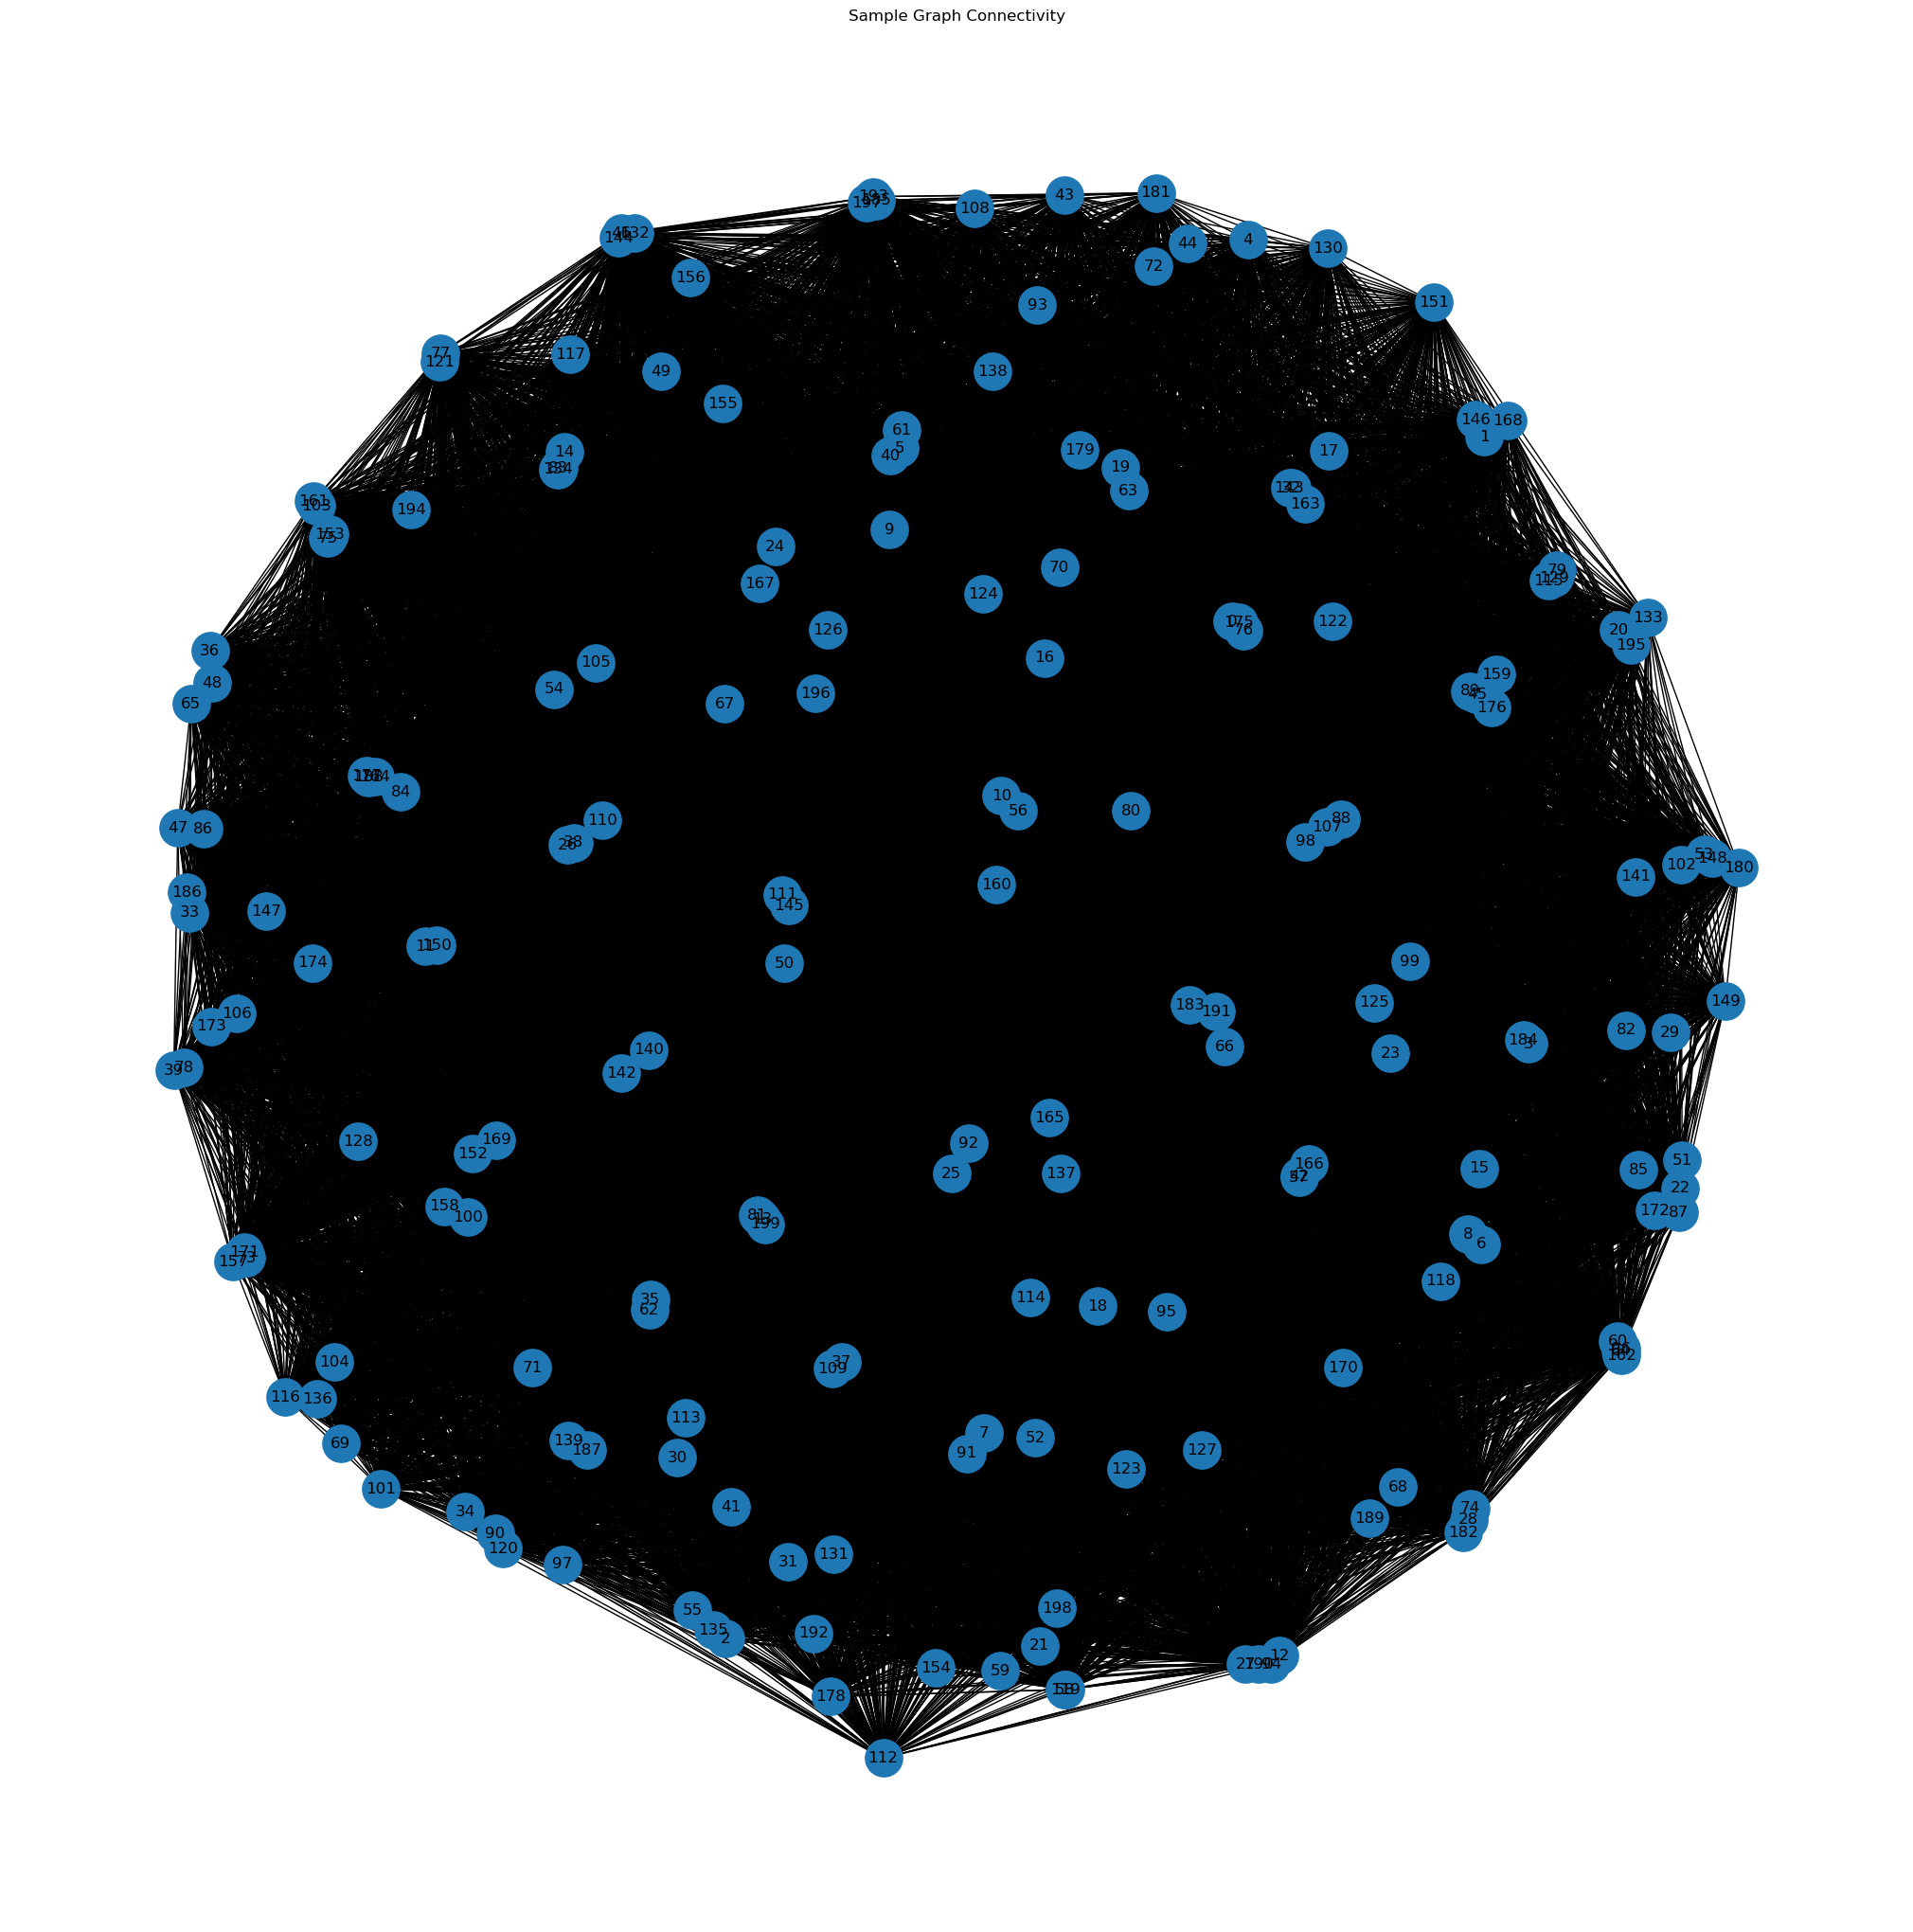

In [34]:
# Convert to NetworkX (no weights)
nx_graph = to_networkx(sample_graph, to_undirected=True)

# Draw the graph
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, with_labels=True, node_size=800, font_size=12)
plt.title("Sample Graph Connectivity")
plt.show()

plt.show()



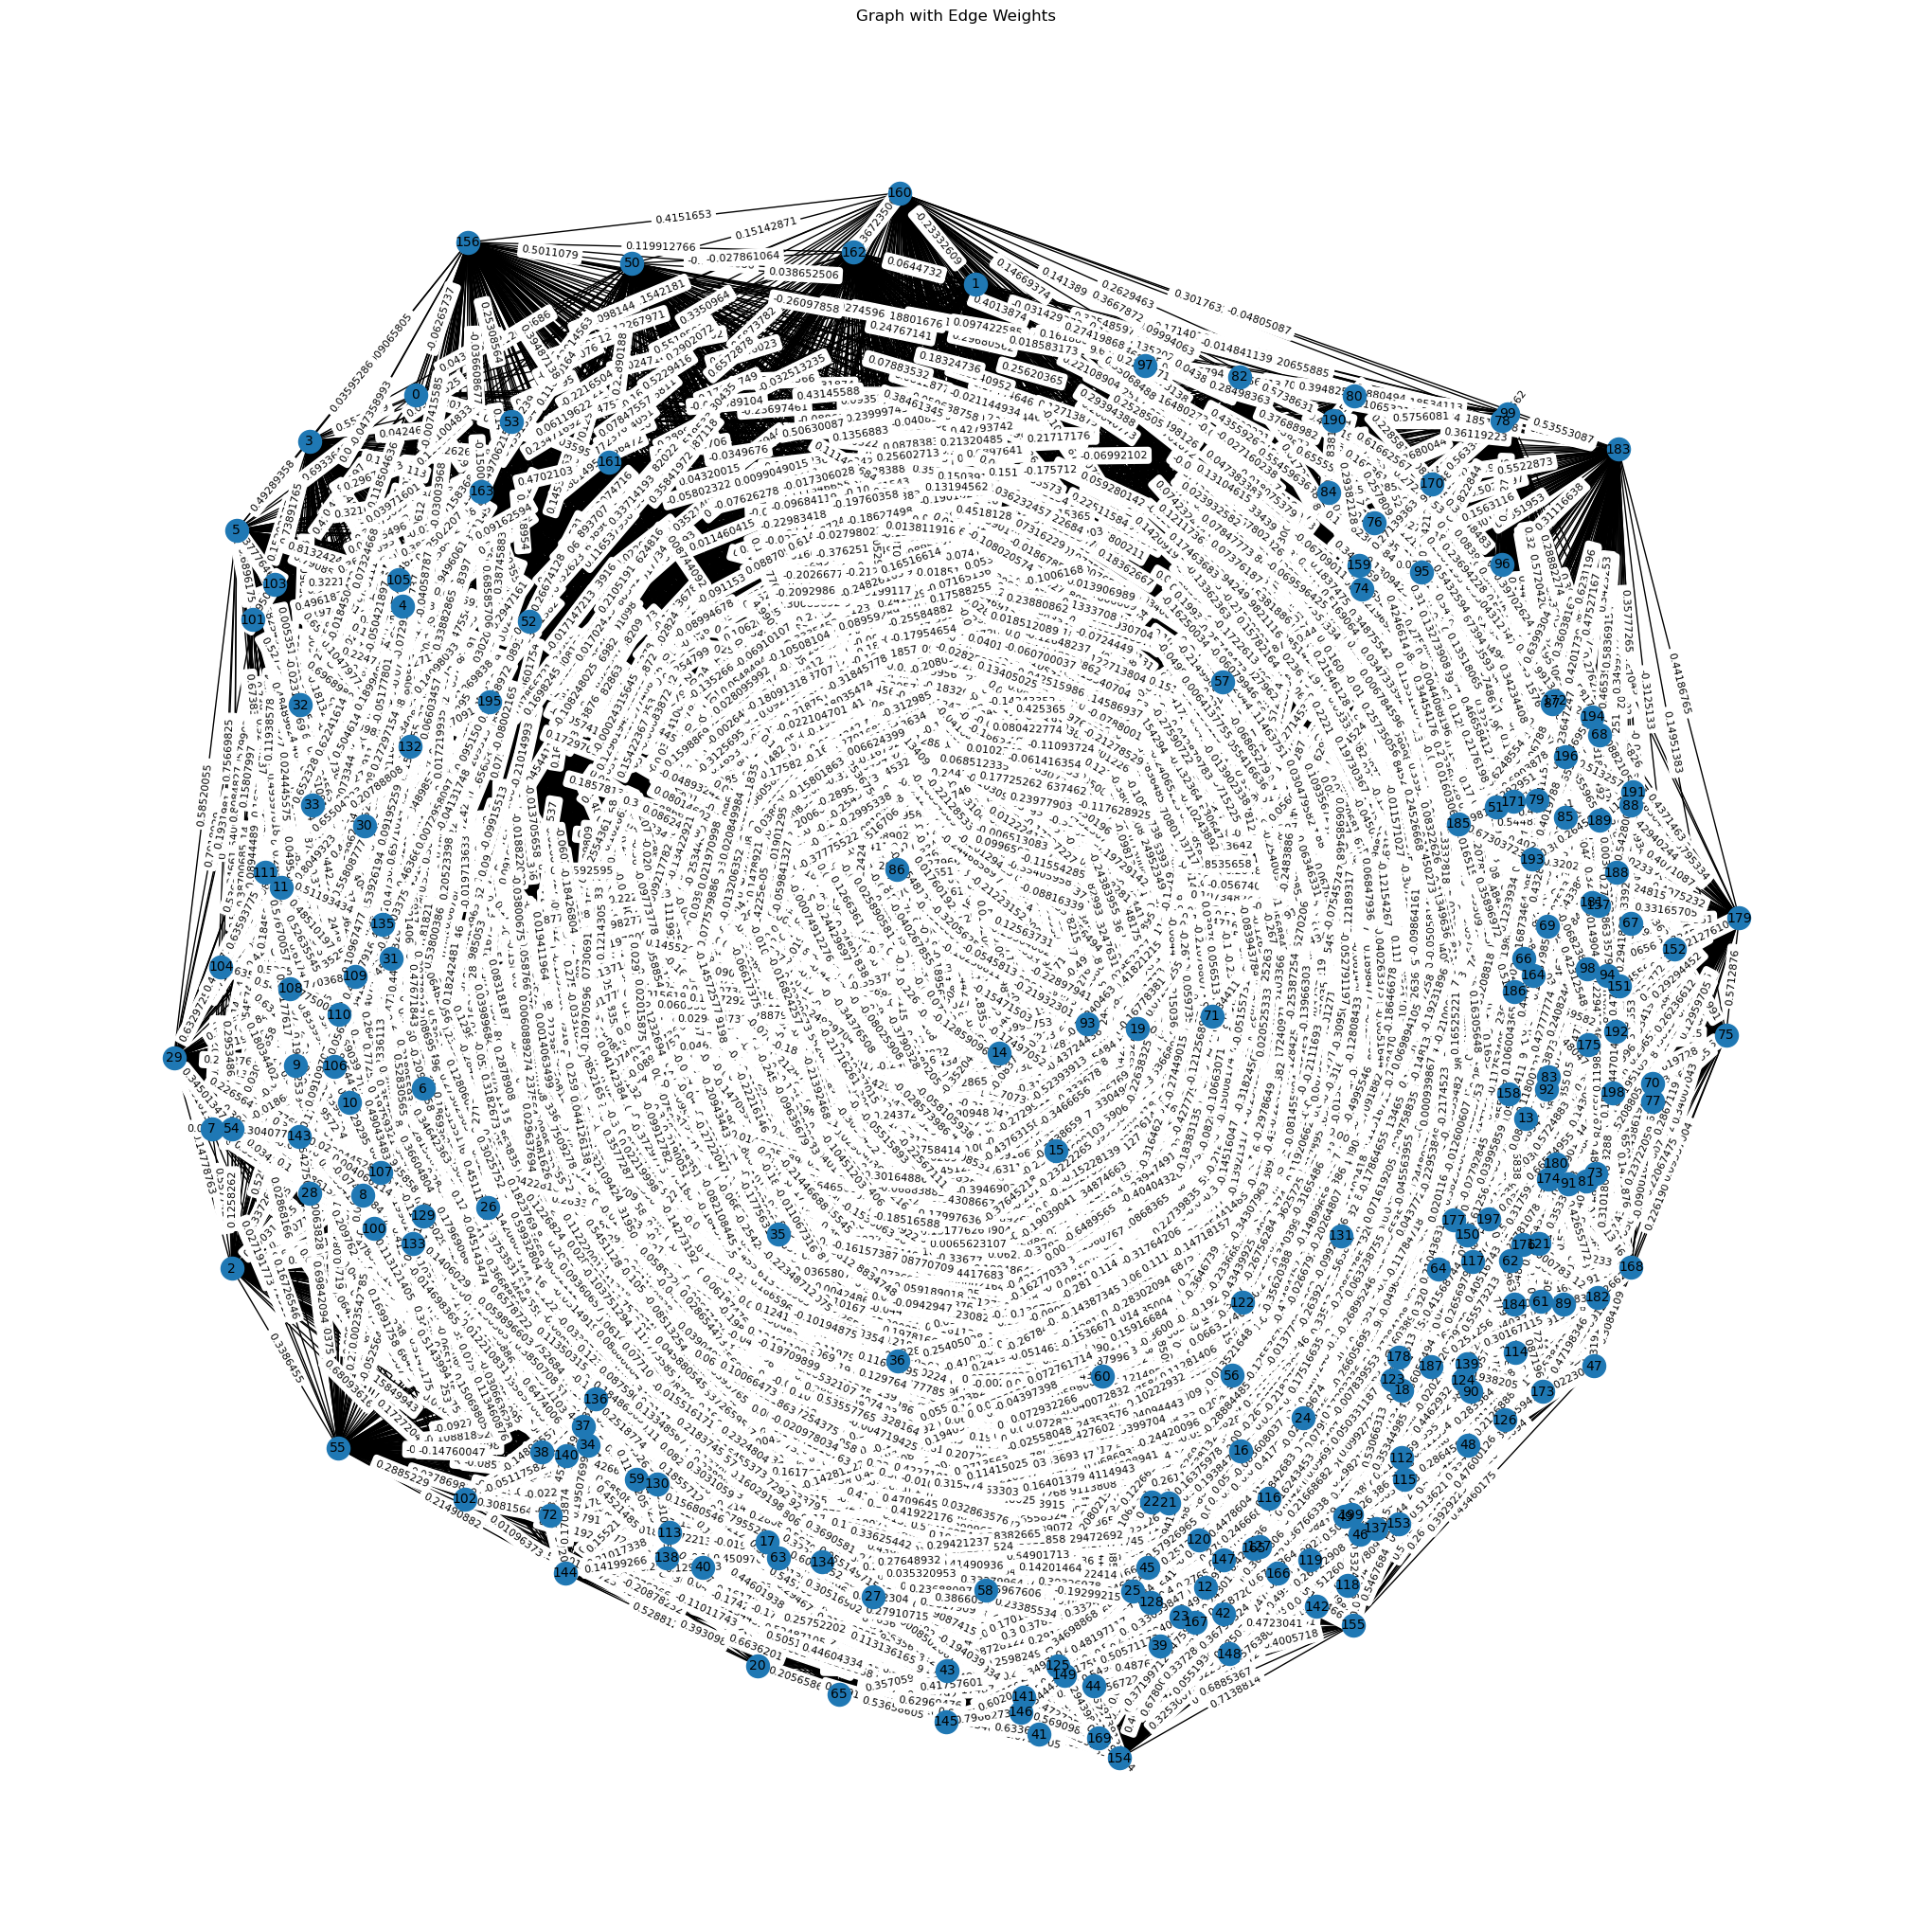

In [35]:
# Add edge weights manually from edge_attr
edge_weights = sample_graph.edge_attr.numpy()
edges = sample_graph.edge_index.numpy().T

# Convert to NetworkX (with weights)
G = nx.Graph()
for (i, j), w in zip(edges, edge_weights):
    G.add_edge(i, j, weight=w)

plt.figure(figsize=(20, 20))
# Draw with edge labels (weights)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Graph with Edge Weights")
plt.show()


In [22]:
num_edges = []
mean_weights = []
max_weights = []
min_weights = []

for graph in test_graph_list:
    num_edges.append(graph.edge_index.shape[1])
    mean_weights.append(graph.edge_attr.mean().item())
    max_weights.append(graph.edge_attr.max().item())
    min_weights.append(graph.edge_attr.min().item())

print("Avg number of edges:", np.mean(num_edges))
print("Mean weight:", np.mean(mean_weights))
print("Max weight:", np.max(max_weights))
print("Min weight:", np.min(min_weights))

Avg number of edges: 39800.0
Mean weight: 0.037090194191765284
Max weight: 0.9834812879562378
Min weight: -0.9063087105751038


### DAE construct

Architecture
- Encoder
- Decoder
- Noise mechanism 
- Loss Function

Components
- GCN layer
- Input Feature - x = torch.eye(200) 
- Output target - Node features (x)
    - DAE reconstructs enhanced node features
    - GNN compatible
    - captures both local structure and noise-robust patterns
    - compact

Noise mechnaisms:
- masking edge weights
- adding Gaussian noise to edge weights
- Perturb X

In [ ]:
# Implement

class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim):
        super().__init__(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return = x

class GNNDecoder(torch.nn.Module):
    def __init__(self, out_dim, hidden_dim, in_channels):
        super(GNNDecoder, self).__init__()
        self.conv1 = GCNConv(out_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x 
    
class DenoisingGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim):
        super(DenoisingGNN, self).__init__()
        self.encoder = GNNEncoder(in_channels, hidden_dim, out_dim)
        self.decoder = GNNDecoder(out_dim, hidden_dim, in_channels)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_reconstructed = self.decoder(z, edge_index)
        return x_reconstructed

